# AIN 214 - PA5 - 2023 on Clustering

This homework aims to deepen your understanding of clustering algorithms and introduce the concept of dimensionality reduction using Principal Component Analysis (PCA). You will use K-Means and Agglomerative Clustering, and explore the impact of PCA on these clustering techniques.



# Student Info
## Name Surname: \<Abdulkadir Parlak\>
## Student ID: \<2210765025\>


## Dataset

We will use the Mall Customer Segmentation Data from Kaggle. The dataset is added to the homework folder - also accessible at [here](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python/).
 

# Necessary Imports

In [66]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import zscore
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler

## 1. Data Cleaning

* **Objective**: Prepare your dataset for analysis.
* **Tasks**: Handle missing values, encode categorical features, handle outliers.

The steps for data cleaning may vary. I do not expect you to use a specific algorithm to handle outliers for example. But **show your work!**


# Handle Missing Values

In [67]:
df = pd.read_csv("Mall_Customers.csv")
missing_values = df.isnull().sum()
print(missing_values)

# I think customerID is redundant in this code:
df.drop('CustomerID', axis=1, inplace=True)

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


Comments:
No missing values in the dataset.

# Encode Categorical Features

In [68]:
# Extract categorical data
categorical_columns = df.select_dtypes(include=['object']).columns

# Extract numerical data
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Apply one hot encoding, actually there exists a shorter method by using the function get_dummies but this approach seemed more 
# controllable to me.
enc = OneHotEncoder()
encoded_data = enc.fit_transform(df[categorical_columns].astype(str)).toarray()

# convert the result into a dataframe
encoded_df = pd.DataFrame(encoded_data, columns=enc.get_feature_names_out(categorical_columns))

# Concatenate the encoded data with the numerical columns 
df_encoded = pd.concat([df[numerical_columns], encoded_df], axis=1)

df_encoded.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
0,19,15,39,0.0,1.0
1,21,15,81,0.0,1.0
2,20,16,6,1.0,0.0
3,23,16,77,1.0,0.0
4,31,17,40,1.0,0.0


# Handle Outliers
Handling method: Z-Score method

In [69]:
# for Age
# Calculate z-score
z_scores_age = zscore(df_encoded['Age'])
z_threshold = 3

# Identify outliers
outliers1_filter = (z_scores_age > z_threshold) | (z_scores_age < -z_threshold)

In [70]:
# for Annual Income
# Calculate z-score
z_scores_annual = zscore(df_encoded['Annual Income (k$)'])

# Identify outliers
outliers2_filter = (z_scores_age > z_threshold) | (z_scores_age < -z_threshold)

In [71]:
# for Spending Score
# Calculate z-score
z_scores_age = zscore(df_encoded['Spending Score (1-100)'])

# Identify outliers
outliers3_filter = (z_scores_age > z_threshold) | (z_scores_age < -z_threshold)

In [72]:
# Remove outliers
df_no_outliers = df_encoded[~outliers1_filter & ~outliers2_filter & ~outliers3_filter]
df_no_outliers

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
0,19,15,39,0.0,1.0
1,21,15,81,0.0,1.0
2,20,16,6,1.0,0.0
3,23,16,77,1.0,0.0
4,31,17,40,1.0,0.0
...,...,...,...,...,...
195,35,120,79,1.0,0.0
196,45,126,28,1.0,0.0
197,32,126,74,0.0,1.0
198,32,137,18,0.0,1.0


Comments:
Zero outliers in this dataset.

## 2. Data Preprocessing

* **Objective**: Transform raw data into a format suitable for ML algorithms: PCA, and clustering, such as normalization.

# Data Normalization

In [73]:
# Encoded dataset does not contain any categorical data but encoded
df_encoded_cols = df_no_outliers[['Gender_Female', 'Gender_Male']]
numerical_cols = df_no_outliers.select_dtypes(include=['int64', 'float64']).columns

# Create a dataframe with only numerical columns
df_numerical = df_no_outliers[numerical_cols]

# Z-Score Standardization
# Apply StandardScaler to numerical columns only
standard_scaler = StandardScaler()
df_standardized = pd.DataFrame(standard_scaler.fit_transform(df_numerical), columns=numerical_cols)

# concatenate standardized numerical columns with categorical(one-hot encoded) columns
df_normalized = pd.concat([df_standardized, df_encoded_cols], axis=1)
df_normalized.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male,Gender_Female,Gender_Male
0,-1.424569,-1.738999,-0.434801,-1.128152,1.128152,0.0,1.0
1,-1.281035,-1.738999,1.195704,-1.128152,1.128152,0.0,1.0
2,-1.352802,-1.700830,-1.715913,0.886405,-0.886405,1.0,0.0
3,-1.137502,-1.700830,1.040418,0.886405,-0.886405,1.0,0.0
4,-0.563369,-1.662660,-0.395980,0.886405,-0.886405,1.0,0.0


## 3. Dimensionality Reduction

### What is Dimensionality Reduction and Why is it Used?
Dimensionality reduction is the process of reducing the number of random variables under consideration by obtaining a set of principal variables. It is an attempt to reduce the complexity of the task as an attempt to remove the curse of dimensionality - also for visualization purposes.

### 3.1. Principal Component Analysis (PCA)
PCA is a technique that transforms original correlated features into new uncorrelated features (principal components) based on variance.
**Process:**
* **Linear Combinations of Features:** PCA begins by creating linear combinations of the existing features in the dataset.
* **First Principal Component:** The first principal component (PC1) is the linear combination that captures the highest variance in the dataset. Mathematically, this is the direction in which the data varies the most.
* **Subsequent Principal Components:** Each following principal component is the linear combination of features that captures the highest variance possible while being orthogonal (perpendicular) to all previously determined principal components. This ensures that each new principal component adds unique information.
* **Covariance Matrix and Eigenvectors:** The process of finding these principal components corresponds to computing the eigenvectors of the covariance matrix of the data. The covariance matrix encapsulates how each pair of variables in the dataset co-varies.
* **Eigenvalues:** The eigenvalues associated with each eigenvector (principal component) indicate the amount of variance that the principal component explains. Larger eigenvalues mean more variance explained.





### 3.2. Apply PCA
* Normalize the data
* Apply PCA to the normalized data using scikit-learn
* Visualize the data with the first two principal components (PC) as the axes. Do you see any clusters?
* Components selection: Visualize the variance explained by each PC. Then choose the number of components that explain the data sufficiently enough.

**Simply use the PCA from sklearn library**

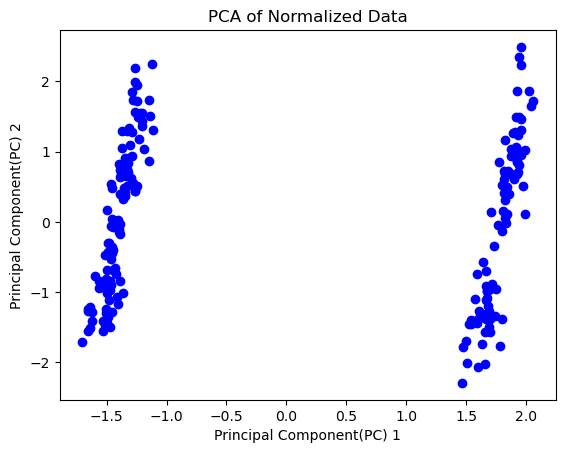

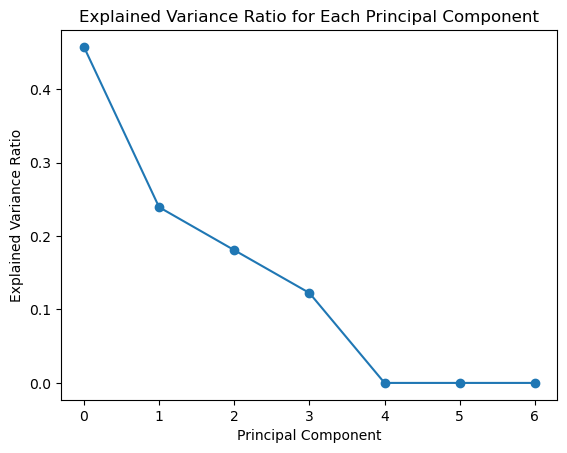

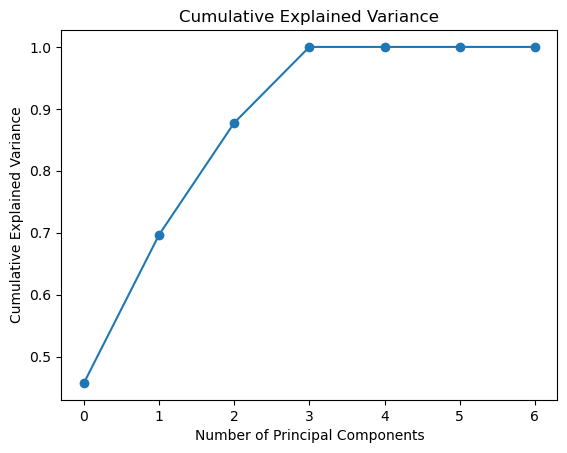

In [74]:
# Data was normalized above.
pca = PCA()

# Fit and transform the normalized data using PCA
principal_components = pca.fit_transform(df_normalized)

# Scatter plot of the first two principal components(PC)
plt.scatter(principal_components[:, 0], principal_components[:, 1], c='b', marker='o')
plt.title('PCA of Normalized Data')
plt.xlabel('Principal Component(PC) 1')
plt.ylabel('Principal Component(PC) 2')
plt.show()

# Visualize the variance explained by each principal component
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio) 

# Plot explained variance ratio
plt.plot(explained_variance_ratio, marker='o')
plt.title('Explained Variance Ratio for Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

# Plot cumulative explained variance
plt.plot(cumulative_variance_ratio, marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

Comments:
In the scatter plot of the first two principal components, we can clearly see that there are 2 main clusters in our dataset.
Optimal number of principal components is 3 in our case. 3 is representing the whole variance sufficiently enough.

## 4. Clustering on the Original Dataset

### 4.1. K-Means Clustering on the Original Dataset

Choose the optimal k using the Elbow method. Then, visualize the resulting clusters with that k.

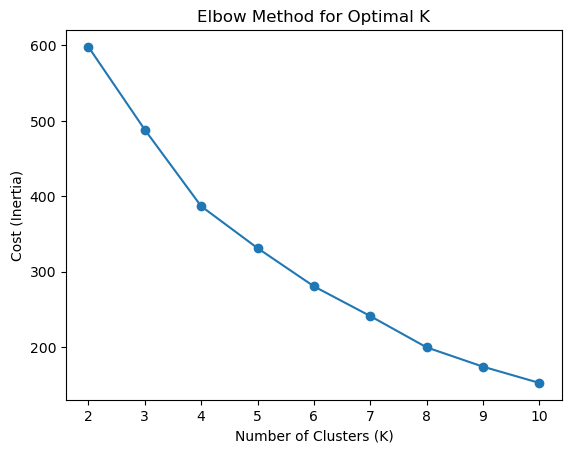

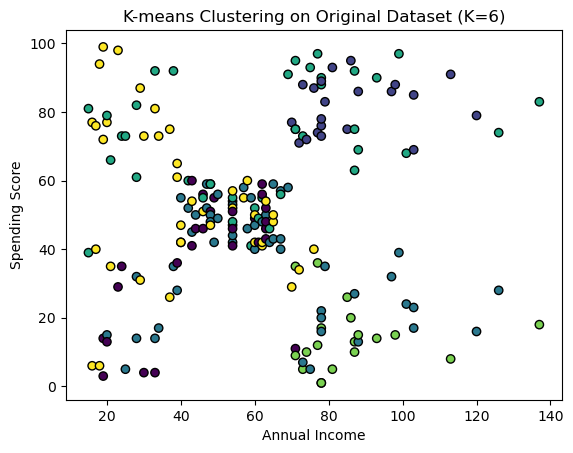

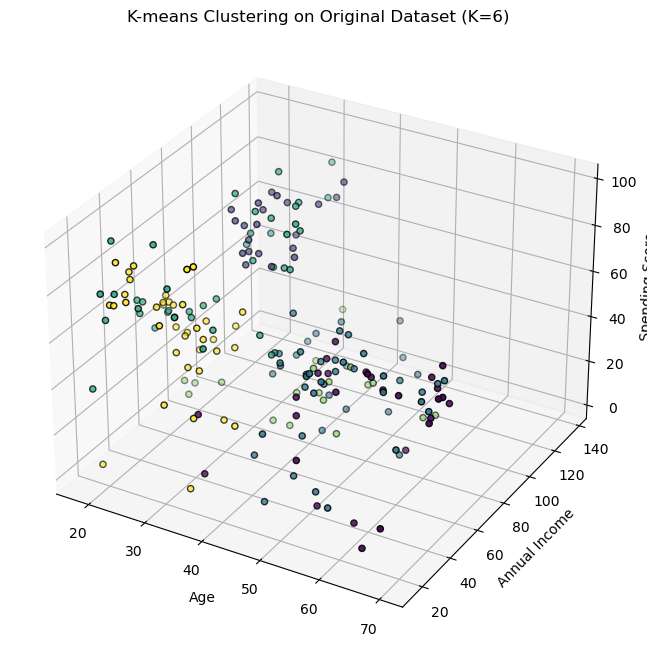

In [75]:
# Apply k-means for a range of values of k
cost = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(df_normalized)
    cost.append(kmeans.inertia_)

# Plot the Elbow Method
plt.plot(range(2, 11), cost, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Cost (Inertia)')
plt.show()

optimal_k = 6

# Apply k-means with the optimal k
kmeans_optimal = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
cluster_labels = kmeans_optimal.fit_predict(df_normalized)

# 2D K-Means result
plt.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'], c=cluster_labels, cmap='viridis', edgecolors='k')
plt.title(f'K-means Clustering on Original Dataset (K={optimal_k})')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.show()

# 3D K-Means result
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['Age'], df['Annual Income (k$)'], df['Spending Score (1-100)'], c=cluster_labels, cmap='viridis', edgecolors='k')

ax.set_title(f'K-means Clustering on Original Dataset (K={optimal_k})')
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income')
ax.set_zlabel('Spending Score')

plt.show()

### 4.2. Hierarchical Agglomerative Clustering (HAC) on the Original Dataset

Apply HAC on the dataset, visualize the dendogram. Then, comment on whether the dendogram agrees with the clusters obtained by K-Means. Try with 2 different linkage methods.

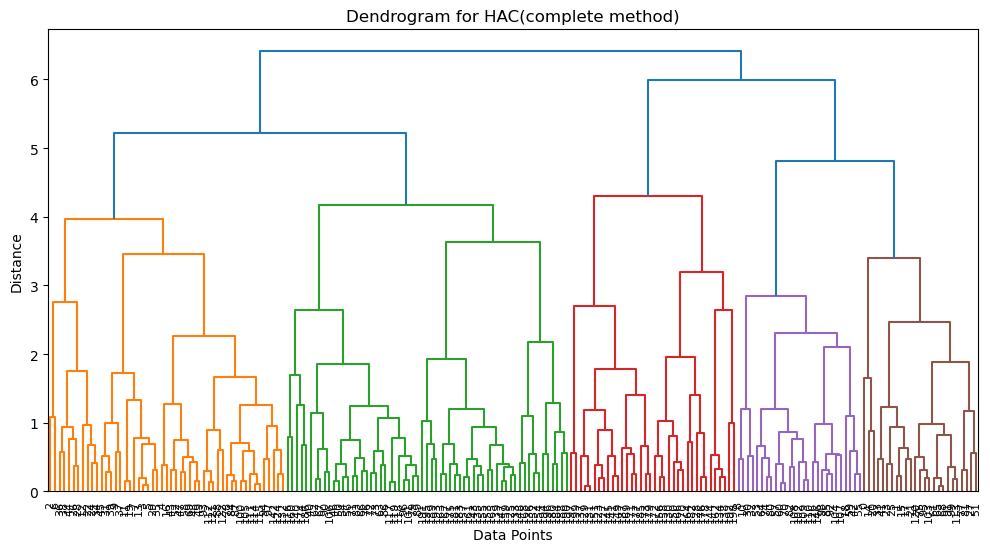

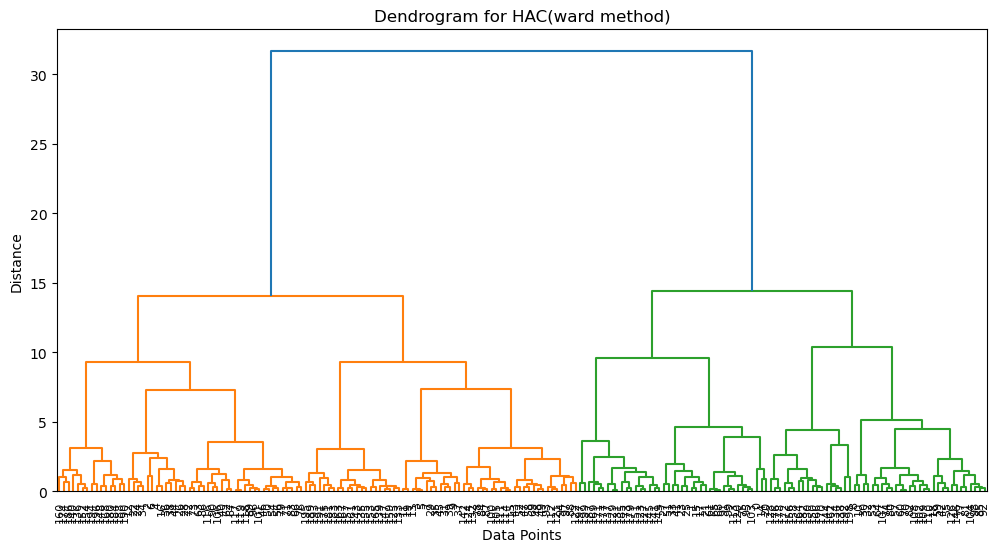

In [76]:
# Compute linkage matrix(complete method)
linkage_matrix = linkage(df_normalized, method='complete')

# Visualize the dendrogram for 'complete' linkage
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, leaf_rotation=90, leaf_font_size=8)
plt.title('Dendrogram for HAC(complete method)')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

# Compute linkage matrix(ward method)
linkage_matrix = linkage(df_normalized, method='ward')

# Visualize the dendrogram for 'ward' linkage
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, leaf_rotation=90, leaf_font_size=8)
plt.title('Dendrogram for HAC(ward method)')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

Comments:
As seen on the dendrograms, there are 6 major clusters in the dataset. It substantially agrees with the results of K-Means
Clustering.
Ward method tries to minimize the variance in each cluster.
Complete method computes the maximum pairwise distance between the members of two clusters. Also known as maximum linkage method.

## 5. K-means Clustering with PCA

Choose the optimal k using the Elbow method. Then, visualize the resulting clusters with that k.

Number of components: 3


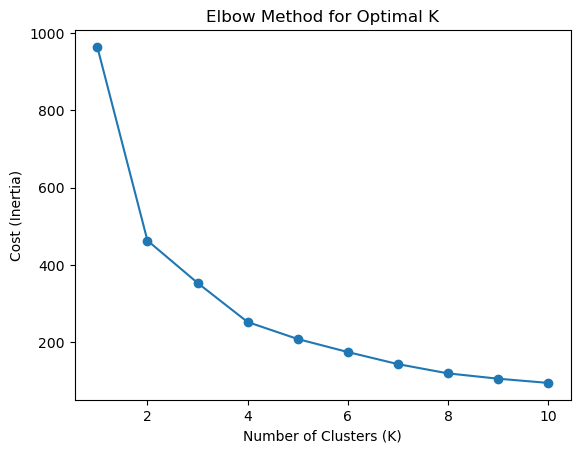

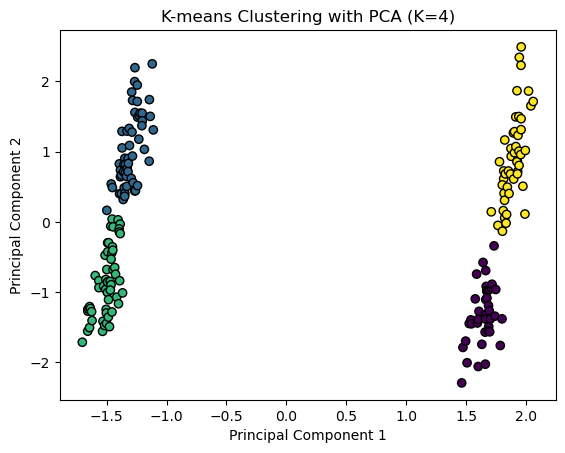

In [77]:
threshold = 0.95
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= threshold) 
print('Number of components: {}'.format(n_components))

pca = PCA(n_components)
principal_components = pca.fit_transform(df_normalized)

# Now, apply K-means clustering for a range of values of k
cost2 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=43)
    kmeans.fit(principal_components)
    cost2.append(kmeans.inertia_)

# Plot the Elbow Method
plt.plot(range(1, 11), cost2, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Cost (Inertia)')
plt.show()
# Inspect the optimal K
optimal_k = 4  # choosing the elbow point visually

# Apply K-means with the optimal k to the dataset with PCA
kmeans_optimal = KMeans(n_clusters=optimal_k, n_init=10, random_state=43)
cluster_labels_pca = kmeans_optimal.fit_predict(principal_components)

# Visualize the resulting clusters
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=cluster_labels_pca, cmap='viridis', edgecolors='k')
plt.title(f'K-means Clustering with PCA (K={optimal_k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## 6. Evaluate the Clustering Results

* Evaluate and compare the clustering results obtained in 4.1 and 5 (k means with and without PCA) using the Silhouette Coefficients.
* Which is better?

In [78]:
# Calculate silhouette coefficients for both clustering with PCA and without PCA
silhouette_coef_no_pca = silhouette_score(df_normalized, cluster_labels)
silhouette_coef_with_pca = silhouette_score(principal_components, cluster_labels_pca)
print("Silhouette Score for no PCA: {}".format(np.round(silhouette_coef_no_pca, 2)))
print("Silhouette Score with PCA: {}".format(np.round(silhouette_coef_with_pca, 2)))

# The silhouette score of near +1 means a better clustering. Since with PCA clustering is closer to the 1, it is more robust
# and gives better results.

Silhouette Score for no PCA: 0.36
Silhouette Score with PCA: 0.42
